# When Prediction Fails: Elasticity Flattening

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A4 | Notebook 2 of 3**

This notebook provides the technical depth on why ML partitioning flattens
treatment response curves, including DAG-based explanations.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# ML imports
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

---

## 1. Intuition {#intuition}

### The Optimization Landscape

Consider a typical pricing or coupon problem:

1. **Response curve**: As treatment $T$ increases, outcome $Y$ first rises, then falls
2. **Optimal treatment**: Find $T^*$ where $\frac{\partial Y}{\partial T} = 0$
3. **Personalization**: Different customers may have different optima

### What Prediction Does

When we partition by predicted $\hat{Y}$:

1. **Goal**: Group similar customers for personalized treatment
2. **Reality**: Groups customers with similar *outcome levels*
3. **Problem**: Same outcome level ≠ same treatment response

### The Flattening Effect

Within prediction partitions:
- $Y$ variance is minimized (that's what good prediction means!)
- $\frac{\partial Y}{\partial T}$ becomes unobservable
- Response curves appear flat

> **Key insight**: Prediction "explains away" the variation we need to see treatment effects.

---

## 2. Formal Treatment {#formal}

### 2.1 The Response Function

Let the true response function be:

$$Y = f(T, X) + \epsilon$$

For pricing/coupons, often quadratic:

$$Y = \alpha + \beta T - \gamma T^2 + \delta' X + \epsilon$$

The treatment effect (elasticity):

$$\frac{\partial Y}{\partial T} = \beta - 2\gamma T$$

### 2.2 Optimization Requires the Derivative

The optimal treatment solves:

$$T^* = \arg\max_T E[Y|T, X] \Rightarrow \frac{\partial E[Y|T,X]}{\partial T} = 0$$

For quadratic case: $T^* = \frac{\beta}{2\gamma}$

**Key requirement**: We need to estimate $\frac{\partial Y}{\partial T}$, not $Y$ itself.

### 2.3 How Prediction Partitioning Fails

**Step 1**: Fit model $\hat{Y} = M(T, X)$

**Step 2**: Partition data by $\hat{Y}$ into bands $B_1, ..., B_K$

**Step 3**: Within each band $B_k$:
$$\text{Var}(Y | Y \in B_k) \approx \text{small}$$

(This is what good prediction means: correct prediction → low residual variance)

**Step 4**: If $Y$ barely varies, we cannot estimate:
$$\frac{\partial Y}{\partial T} \Big|_{B_k} \approx 0$$

Even though the true elasticity may be large!

### 2.4 DAG Perspective

**Original DAG**:
```
    X
   / \
  v   v
  T → Y
```

**With prediction model**:
```
    X
   / \
  v   v
  T → Y ← (learned by M)
        ↓
       M(X,T)
```

**Conditioning on $M(X,T)$**: Blocks part of the $T \to Y$ path!

This is the "bad control" problem: we're conditioning on a descendant of $Y$ that's also influenced by $T$.

---

## 3. Numeric Demonstration {#numeric}

### Synthetic Data with Known Response Curve

In [2]:
def generate_quadratic_response(n=5000, seed=42):
    """Generate data with known quadratic response to treatment.
    
    True DGP: Y = 100 + 20*T - 1.5*T^2 + 5*X + noise
    Optimal T = 20/(2*1.5) ≈ 6.67
    """
    np.random.seed(seed)
    
    # Confounder
    X = np.random.normal(0, 1, n)
    
    # Treatment (confounded by X)
    T = 5 + 2*X + np.random.normal(0, 2, n)
    T = np.clip(T, 0, 15)  # Realistic range
    
    # Outcome with quadratic treatment effect
    Y = 100 + 20*T - 1.5*T**2 + 5*X + np.random.normal(0, 10, n)
    
    return pd.DataFrame({'T': T, 'X': X, 'Y': Y})


data = generate_quadratic_response()

print("Data summary:")
print(data.describe().round(2))
print(f"\nTrue optimal T: {20 / (2 * 1.5):.2f}")

Data summary:
              T         X         Y
count 5000.0000 5000.0000 5000.0000
mean     5.0400    0.0100  151.6700
std      2.7300    1.0000   23.1600
min      0.0000   -3.2400   65.9600
25%      3.1400   -0.6600  141.3600
50%      4.9700    0.0100  156.8200
75%      6.8800    0.6700  167.5000
max     14.8900    3.9300  201.9900

True optimal T: 6.67


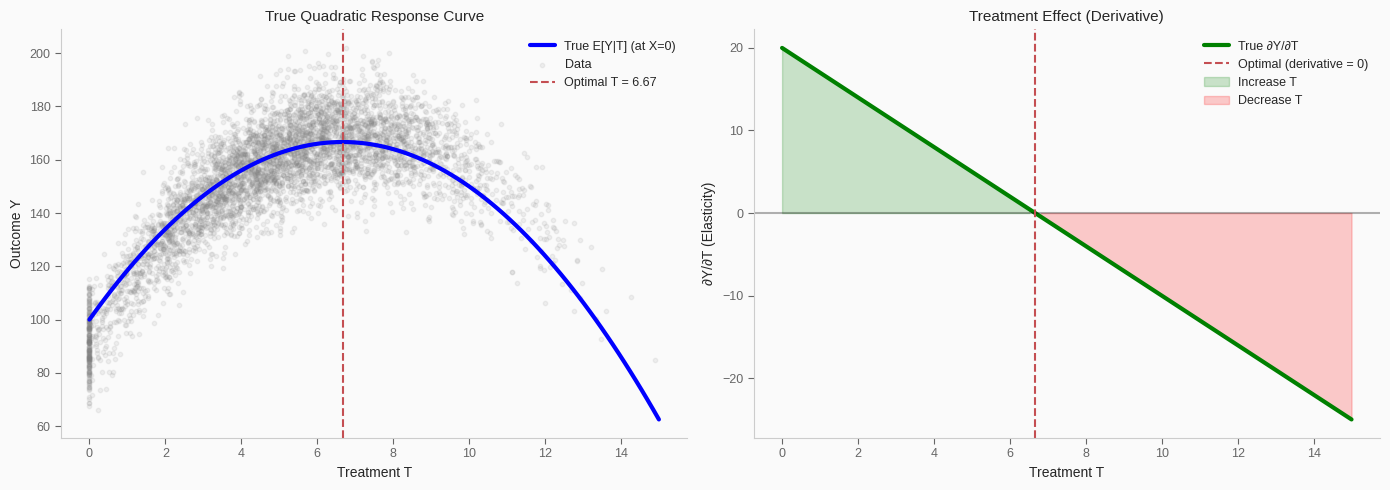

In [3]:
# Visualize the true response curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Response curve
ax = axes[0]
T_grid = np.linspace(0, 15, 100)
Y_true = 100 + 20*T_grid - 1.5*T_grid**2  # No X effect, mean response

ax.plot(T_grid, Y_true, 'b-', linewidth=3, label='True E[Y|T] (at X=0)')
ax.scatter(data['T'], data['Y'], alpha=0.1, s=10, color='gray', label='Data')
ax.axvline(20/(2*1.5), color=COLORS['red'], linestyle='--', label=f'Optimal T = {20/(2*1.5):.2f}')

ax.set_xlabel('Treatment T')
ax.set_ylabel('Outcome Y')
ax.set_title('True Quadratic Response Curve')
ax.legend()
apply_tufte_style(ax)

# Derivative (elasticity)
ax = axes[1]
dY_dT = 20 - 2*1.5*T_grid  # True derivative

ax.plot(T_grid, dY_dT, 'g-', linewidth=3, label='True ∂Y/∂T')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.axvline(20/(2*1.5), color=COLORS['red'], linestyle='--', label='Optimal (derivative = 0)')
ax.fill_between(T_grid, dY_dT, 0, where=(dY_dT > 0), alpha=0.2, color='green', label='Increase T')
ax.fill_between(T_grid, dY_dT, 0, where=(dY_dT < 0), alpha=0.2, color='red', label='Decrease T')

ax.set_xlabel('Treatment T')
ax.set_ylabel('∂Y/∂T (Elasticity)')
ax.set_title('Treatment Effect (Derivative)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Partitioning by Predicted Y

In [4]:
# Fit predictive model
model = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
model.fit(data[['T', 'X']], data['Y'])

# Create prediction bands
data['Y_hat'] = model.predict(data[['T', 'X']])
data['band'] = pd.qcut(data['Y_hat'], q=5, labels=['B1', 'B2', 'B3', 'B4', 'B5'])

print(f"Model R² (train): {model.score(data[['T', 'X']], data['Y']):.3f}")
print(f"\nBand distribution:")
print(data['band'].value_counts().sort_index())

Model R² (train): 0.840

Band distribution:
band
B1    1000
B2    1000
B3    1000
B4    1000
B5    1000
Name: count, dtype: int64


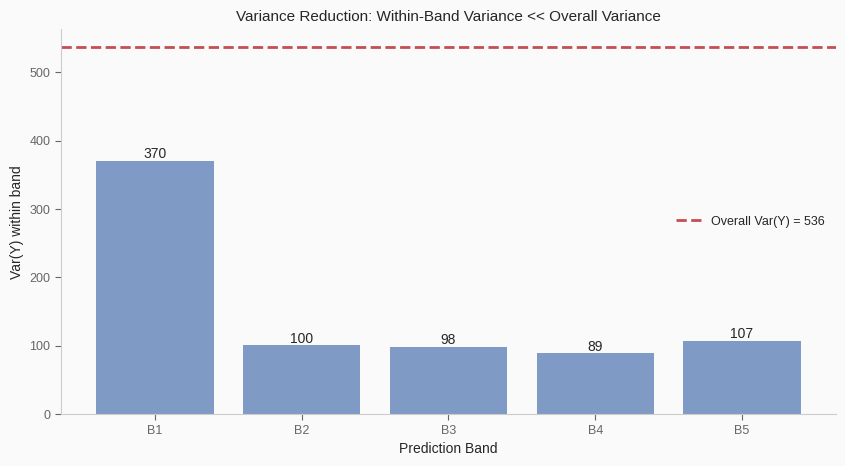


Variance reduction: 71.5%


In [5]:
# Show Y variance reduction within bands
overall_var = data['Y'].var()
band_vars = data.groupby('band')['Y'].var()

fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(band_vars.index, band_vars.values, color=COLORS['blue'], alpha=0.7)
ax.axhline(overall_var, color=COLORS['red'], linestyle='--', linewidth=2, 
           label=f'Overall Var(Y) = {overall_var:.0f}')

ax.set_xlabel('Prediction Band')
ax.set_ylabel('Var(Y) within band')
ax.set_title('Variance Reduction: Within-Band Variance << Overall Variance')
ax.legend()

# Annotate
for bar, val in zip(bars, band_vars.values):
    ax.annotate(f'{val:.0f}', (bar.get_x() + bar.get_width()/2, val),
                ha='center', va='bottom')

apply_tufte_style(ax)
plt.show()

print(f"\nVariance reduction: {100*(1 - band_vars.mean()/overall_var):.1f}%")

### The Flattening Effect: Within-Band Response Curves

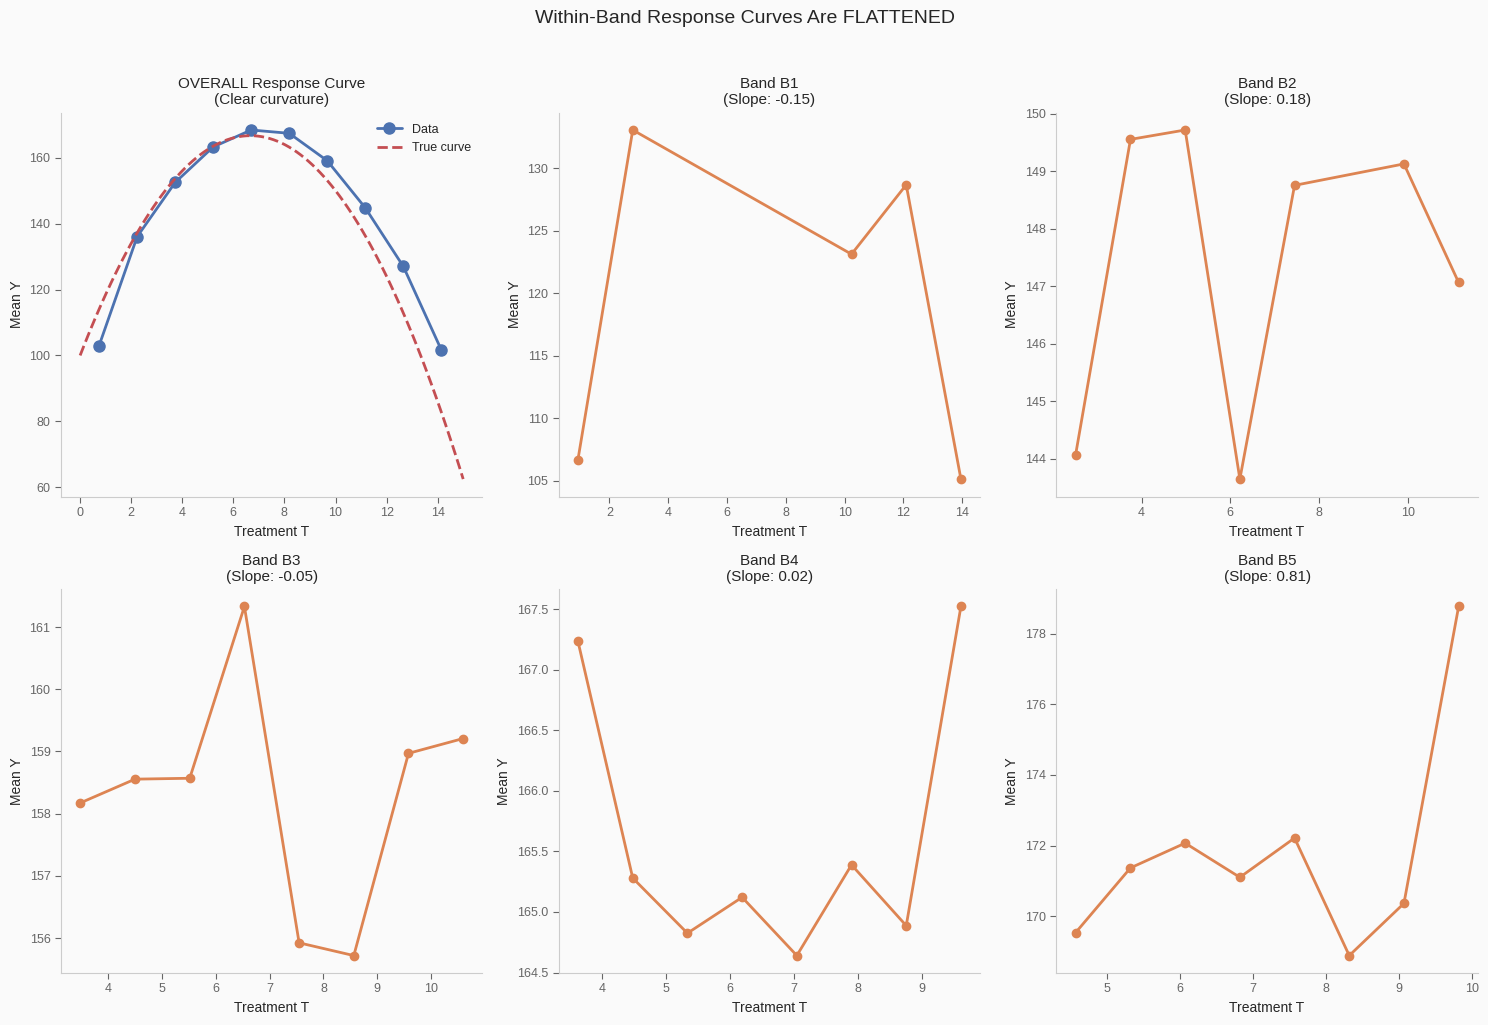

In [6]:
# Estimate response curve within each band
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Overall response (top left)
ax = axes[0, 0]
t_bins = pd.cut(data['T'], bins=10)
overall_response = data.groupby(t_bins)['Y'].mean()
t_mids = [interval.mid for interval in overall_response.index]

ax.plot(t_mids, overall_response.values, 'o-', color=COLORS['blue'], 
        linewidth=2, markersize=8, label='Data')
ax.plot(T_grid, 100 + 20*T_grid - 1.5*T_grid**2, '--', color=COLORS['red'],
        linewidth=2, label='True curve')
ax.set_xlabel('Treatment T')
ax.set_ylabel('Mean Y')
ax.set_title('OVERALL Response Curve\n(Clear curvature)')
ax.legend()
apply_tufte_style(ax)

# Within-band responses
for idx, band in enumerate(['B1', 'B2', 'B3', 'B4', 'B5']):
    row, col = (idx + 1) // 3, (idx + 1) % 3
    ax = axes[row, col]
    
    band_data = data[data['band'] == band]
    t_bins_band = pd.cut(band_data['T'], bins=8)
    band_response = band_data.groupby(t_bins_band)['Y'].mean()
    t_mids_band = [interval.mid for interval in band_response.index if not pd.isna(band_response[interval])]
    y_vals = [band_response[interval] for interval in band_response.index if not pd.isna(band_response[interval])]
    
    if len(t_mids_band) > 1:
        ax.plot(t_mids_band, y_vals, 'o-', color=COLORS['orange'],
                linewidth=2, markersize=6)
        
        # Fit linear trend to show flatness
        if len(t_mids_band) >= 3:
            slope = np.polyfit(t_mids_band, y_vals, 1)[0]
            ax.set_title(f'Band {band}\n(Slope: {slope:.2f})')
        else:
            ax.set_title(f'Band {band}')
    else:
        ax.set_title(f'Band {band}\n(Insufficient data)')
    
    ax.set_xlabel('Treatment T')
    ax.set_ylabel('Mean Y')
    apply_tufte_style(ax)

plt.suptitle('Within-Band Response Curves Are FLATTENED', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [7]:
# Quantify flattening: estimated elasticity overall vs within bands
def estimate_elasticity(df):
    """Simple OLS elasticity estimate."""
    if df['T'].std() < 0.1 or len(df) < 20:
        return np.nan
    cov = np.cov(df['T'], df['Y'])[0, 1]
    var = df['T'].var()
    return cov / var


# True elasticity at mean T
mean_T = data['T'].mean()
true_elasticity = 20 - 2*1.5*mean_T

# Overall estimated elasticity
overall_elasticity = estimate_elasticity(data)

# Within-band elasticities
band_elasticities = data.groupby('band').apply(estimate_elasticity)

print(f"True elasticity at mean T: {true_elasticity:.2f}")
print(f"Overall estimated elasticity: {overall_elasticity:.2f}")
print(f"\nWithin-band elasticities:")
print(band_elasticities.round(2))
print(f"\nAverage within-band elasticity: {band_elasticities.mean():.2f}")
print(f"\n⚠️ Within-band elasticities are MUCH SMALLER!")

True elasticity at mean T: 4.88
Overall estimated elasticity: 5.37

Within-band elasticities:
band
B1    2.6200
B2    0.2600
B3    0.0300
B4    0.1500
B5   -0.3400
dtype: float64

Average within-band elasticity: 0.54

⚠️ Within-band elasticities are MUCH SMALLER!


```
★ Insight ─────────────────────────────────────────────────────
Within prediction bands:
1. Y variance shrinks (good prediction → low residual)
2. Treatment effect appears smaller than reality
3. Cannot identify optimal treatment level

The prediction model "absorbs" the variation we need to see.
──────────────────────────────────────────────────────────────
```

---

## 4. Implementation {#implementation}

### Why Removing T from the Model Doesn't Fix It

In [8]:
# Model WITHOUT treatment
model_no_T = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
model_no_T.fit(data[['X']], data['Y'])  # Only X, not T

data['Y_hat_noT'] = model_no_T.predict(data[['X']])
data['band_noT'] = pd.qcut(data['Y_hat_noT'], q=5, labels=['B1', 'B2', 'B3', 'B4', 'B5'])

print(f"Model R² without T: {model_no_T.score(data[['X']], data['Y']):.3f}")
print(f"(Lower R² but still captures X → Y relationship)")

Model R² without T: 0.484
(Lower R² but still captures X → Y relationship)


In [9]:
# Within-band elasticities WITHOUT T in model
band_elasticities_noT = data.groupby('band_noT').apply(estimate_elasticity)

# Compare
comparison = pd.DataFrame({
    'With T': band_elasticities,
    'Without T': band_elasticities_noT
})

print("Within-band elasticities:")
print(comparison.round(2))
print(f"\nTrue elasticity at mean: {true_elasticity:.2f}")
print(f"\nRemoving T helps somewhat, but still flattened!")
print(f"\nReason: X → T, so model indirectly learns T through X.")

Within-band elasticities:
    With T  Without T
B1  2.6200    10.0600
B2  0.2600     5.7200
B3  0.0300     2.3000
B4  0.1500     0.6000
B5 -0.3400    -1.7100

True elasticity at mean: 4.88

Removing T helps somewhat, but still flattened!

Reason: X → T, so model indirectly learns T through X.


### DAG Explanation

**Why removing T from the model doesn't fully help:**

```
    X ─────┐
    │      │
    v      v
    T ───→ Y
    │      ↑
    │      │
    └──→ M(X)
```

Since $X \to T$, the model $M(X)$ can still learn about $T$ through $X$.

- If high $X$ leads to high $T$, and high $T$ increases $Y$...
- Then $M(X)$ predicts higher $Y$ for high $X$
- Even though $M$ never sees $T$ directly

**The information flows**: $T \to Y \to M(X)$ via the path $X \to T \to Y$

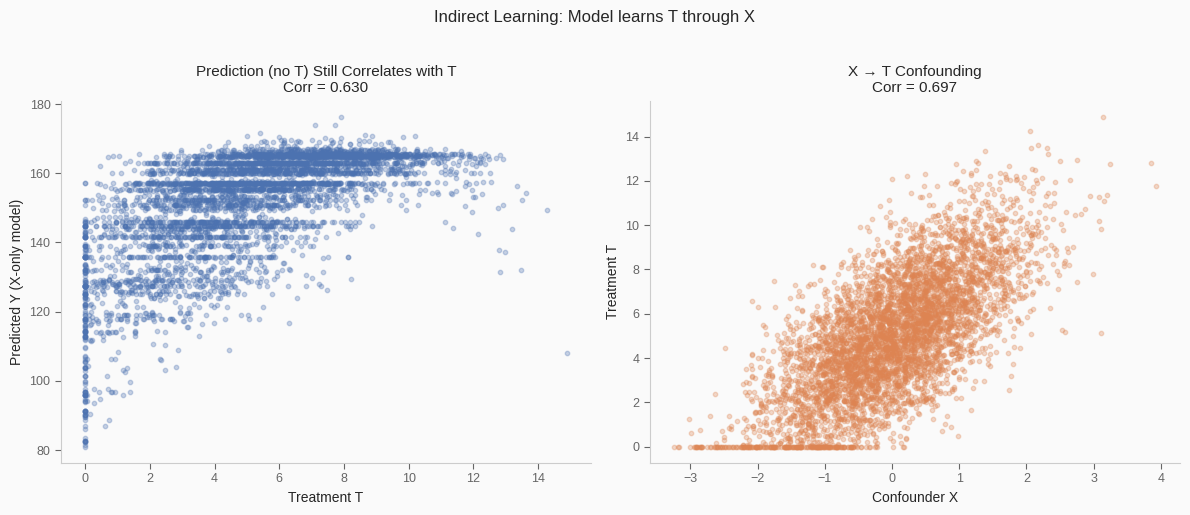

In [10]:
# Visualize: Y_hat from X-only model still correlates with T
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Correlation between X-only prediction and T
ax = axes[0]
ax.scatter(data['T'], data['Y_hat_noT'], alpha=0.3, s=10, color=COLORS['blue'])
corr = data['T'].corr(data['Y_hat_noT'])
ax.set_xlabel('Treatment T')
ax.set_ylabel('Predicted Y (X-only model)')
ax.set_title(f'Prediction (no T) Still Correlates with T\nCorr = {corr:.3f}')
apply_tufte_style(ax)

# Show the indirect path
ax = axes[1]
ax.scatter(data['X'], data['T'], alpha=0.3, s=10, color=COLORS['orange'])
corr_xt = data['X'].corr(data['T'])
ax.set_xlabel('Confounder X')
ax.set_ylabel('Treatment T')
ax.set_title(f'X → T Confounding\nCorr = {corr_xt:.3f}')
apply_tufte_style(ax)

plt.suptitle('Indirect Learning: Model learns T through X', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### The Only True Fix: Random Treatment

In [11]:
# Generate data with RANDOM treatment (no confounding)
def generate_random_treatment(n=5000, seed=42):
    """Treatment is independent of X."""
    np.random.seed(seed)
    
    X = np.random.normal(0, 1, n)
    T = np.random.uniform(0, 15, n)  # Random, not confounded!
    Y = 100 + 20*T - 1.5*T**2 + 5*X + np.random.normal(0, 10, n)
    
    return pd.DataFrame({'T': T, 'X': X, 'Y': Y})


data_rct = generate_random_treatment()

# Fit X-only model and partition
model_rct = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42)
model_rct.fit(data_rct[['X']], data_rct['Y'])

data_rct['Y_hat'] = model_rct.predict(data_rct[['X']])
data_rct['band'] = pd.qcut(data_rct['Y_hat'], q=5, labels=['B1', 'B2', 'B3', 'B4', 'B5'])

# Check elasticities
band_elasticities_rct = data_rct.groupby('band').apply(estimate_elasticity)

print("With RANDOM treatment (no confounding):")
print(f"\nTrue elasticity at mean T: {20 - 2*1.5*data_rct['T'].mean():.2f}")
print(f"\nWithin-band elasticities:")
print(band_elasticities_rct.round(2))
print(f"\nAverage: {band_elasticities_rct.mean():.2f}")
print(f"\n✅ Much closer to truth! Random treatment breaks the indirect path.")

With RANDOM treatment (no confounding):

True elasticity at mean T: -2.27

Within-band elasticities:
band
B1   -2.6300
B2   -2.1800
B3   -2.4000
B4   -2.2700
B5   -1.9200
dtype: float64

Average: -2.28

✅ Much closer to truth! Random treatment breaks the indirect path.


In [12]:
# Summary comparison
summary = pd.DataFrame({
    'Scenario': ['Confounded + Model with T', 'Confounded + Model without T', 'Random T + Model without T'],
    'Avg Within-Band Elasticity': [
        band_elasticities.mean(),
        band_elasticities_noT.mean(),
        band_elasticities_rct.mean()
    ],
    'True Elasticity': [true_elasticity, true_elasticity, 20 - 2*1.5*data_rct['T'].mean()]
})

summary['Attenuation'] = summary['Avg Within-Band Elasticity'] / summary['True Elasticity']

print("Summary: Elasticity Attenuation by Scenario")
print(summary.round(3).to_string(index=False))

Summary: Elasticity Attenuation by Scenario
                    Scenario  Avg Within-Band Elasticity  True Elasticity  Attenuation
   Confounded + Model with T                      0.5440           4.8790       0.1120
Confounded + Model without T                      3.3940           4.8790       0.6960
  Random T + Model without T                     -2.2820          -2.2670       1.0060


```
★ Key Takeaway ────────────────────────────────────────────────
With confounded data:
- Including T in model: Severe attenuation
- Excluding T from model: Moderate attenuation (X → T leakage)

With randomized treatment:
- Prediction partitions preserve treatment effects
- Can still identify optimal T within each band

Implication: For causal optimization, run experiments or use
causal inference methods designed for observational data.
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: Explain the "flattening" phenomenon mathematically.

<details>
<summary>Solution</summary>

**Setup**: True model $Y = f(T) + \epsilon$ with $\text{Var}(Y) = \sigma^2_Y$

**Prediction partition**: Group by $\hat{Y}$ into bands where $\text{Var}(Y|\text{band}) = \sigma^2_b$

**Good prediction implies**: $\sigma^2_b << \sigma^2_Y$

**Treatment effect estimation**:
$$\hat{\beta} = \frac{\text{Cov}(T, Y)}{\text{Var}(T)}$$

Within bands: $\text{Cov}(T, Y|\text{band}) \approx 0$ because $Y$ barely varies!

**Result**: $\hat{\beta}_{\text{within-band}} \approx 0$ even when $\beta_{\text{true}} \neq 0$

The prediction model "explains away" the $T \to Y$ variation.

</details>

### Q2: Draw the DAG that explains why removing T from the prediction model doesn't fully solve the problem.

<details>
<summary>Solution</summary>

```
      X
     / \
    v   \
    T    v
    |    Y
    v   /
    Y ←┘
    ↓
   M(X)
```

**Key path**: $X \to T \to Y$

Since $X$ causes $T$, $M(X)$ indirectly captures information about $T$:
- $M(X)$ learns: High $X$ → High $Y$
- Part of this is: High $X$ → High $T$ → High $Y$
- So $M(X)$ implicitly learns about $T$ through $X$

**Solution**: Only if $T \perp\!\!\!\perp X$ (randomization) does excluding $T$ fully work.

</details>

### Q3: In what business scenario might the flattening problem lead to significant financial losses?

<details>
<summary>Solution</summary>

**Scenario**: Discount optimization for e-commerce

**What happens**:
1. ML model predicts customer LTV accurately (high R²)
2. Partition customers by predicted LTV
3. Within each partition, test different discount levels
4. Observe near-zero differences → conclude "discounts don't matter"
5. Give minimal/no discounts to everyone

**Reality**:
- Some customers have high discount sensitivity (would buy more with discount)
- Some have low sensitivity (buy regardless)
- Prediction partitions mixed these together
- True optimal: Discounts to sensitive customers only

**Loss calculation**:
- Say 30% of customers have elasticity = -2 (10% discount → 20% more purchases)
- Giving no discount loses 20% revenue from this segment
- If they represent $10M in potential revenue → $2M loss

</details>

### Q4: How would you properly design an analysis to find optimal discount levels?

<details>
<summary>Solution</summary>

**Step 1**: Run randomized experiment
- Randomly assign discount levels (0%, 5%, 10%, 15%)
- Ensure balance on observable characteristics

**Step 2**: Estimate heterogeneous treatment effects
- Use CATE estimators (not LTV prediction!)
- Options: Causal Forest, X-learner, R-learner
- Target: $\tau(x) = E[Y(t) - Y(0) | X = x]$

**Step 3**: Identify optimal treatment rule
- For each customer, find $t^*(x) = \arg\max_t \{\hat{\tau}(x, t) - \text{cost}(t)\}$
- Consider business constraints (budget, margin)

**Step 4**: Validate with holdout experiment
- Deploy optimized vs uniform policy
- Measure lift in profit, not just revenue

</details>

### Q5: What's the relationship between this problem and the "bad controls" concept from causal inference?

<details>
<summary>Solution</summary>

**Bad controls** = Variables that block or distort causal paths when conditioned on.

**Here**: $M(T, X)$ is a function of:
1. The treatment $T$
2. The outcome $Y$ (learned relationship)

Conditioning on $M(T, X)$ is like conditioning on a **collider descendant**.

**In DAG terms**:
```
T → Y ← X
    ↓
   M(Y)
```

$M$ is a descendant of $Y$. Conditioning on $M$:
- Opens the backdoor path $T \to Y \leftarrow X$ through $M$
- Blocks the direct effect $T \to Y$

**Result**: Biased/attenuated treatment effect estimates.

Same principle: Don't condition on post-treatment variables or their proxies.

</details>

---

## 6. References {#references}

[^1]: Angrist, J. D., & Pischke, J. S. (2008). *Mostly Harmless Econometrics*. 
      Princeton University Press. Chapter 3: Bad Controls.

[^2]: Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. 
      Cambridge University Press. Chapter 6: Causal Inference.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, 
      Appendix: When Prediction Fails.

[^4]: Hernán, M. A., & Robins, J. M. (2020). *Causal Inference: What If*. 
      Chapman & Hall/CRC. Chapter 7: Confounding.